In [2]:
import requests
import json
# import prettytable
import pandas as pd
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


####State and Area Employment, Hours and Earnings (SM) 

http://download.bls.gov/pub/time.series/sm/

from sm.txt, find series id for hourly earnings in private sector in california


In [3]:
# data_type_code
lookup_dataType = pd.read_csv("smdata_type.txt", delimiter="\t", index_col=False)
earnings = lookup_dataType[lookup_dataType.data_type_text.str.contains("Hourly Earnings of All Employees")].data_type_code
hours = lookup_dataType[lookup_dataType.data_type_text.str.contains("Weekly Hours of All Employees")].data_type_code

# area_code
lookup_areaCode = pd.read_csv("smarea.txt", delimiter="\t", index_col=False)
area = lookup_areaCode[lookup_areaCode.area_name.str.contains("San Francisco")].area_code

# industry_code, don't need for SF because industry is Total Private
# lookup_industry = pd.read_csv("smindustry.txt", delimiter="\t", index_col=False)

In [5]:
#find series to post requests
series = pd.read_csv("smseries.txt", delim_whitespace=True)
series_earnings = series[series.data_type_code.isin(earnings.values) & \
                         (series.industry_code == 5000000) & (series.state_code == 6)].series_id.values
# sf : series.area_code.isin(area.values) & \
# series_hours = series[series.area_code.isin(area.values) & \
#                       (series.industry_code == 5000000) & (series.state_code == 6)].series_id.values

In [6]:
def get_data(seriesid_array):
    headers = {'Content-type': 'application/json'}
    data = json.dumps({"seriesid": list(seriesid_array), 'registrationKey': 'a4c5b701a8604c5a98f3e4a92a83c4f6',
                      "startyear": "2000", "endyear": "2015"})
    #multiple series id use post
    p = requests.post('http://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers)
    json_data = json.loads(p.text) 
    df = pd.DataFrame(columns=["series id","year","period","value","footnotes"])
    i = 0
    for s in json_data['Results']['series']:
        seriesId = s['seriesID']
        for item in s['data']:
            year = item['year']
            period = item['period']
            value = item['value']
            footnotes=""
            for footnote in item['footnotes']:
                if footnote:
                    footnotes = footnotes + footnote['text'] + ','
           #'if 'M01' <= period <= 'M12':'
                df.loc[i] = (seriesId,year,period,value,footnotes[0:-1])
                i+=1
    return df
#     output = open(seriesId + '.txt','w')
#     output.write (x.get_string())
#     output.close()

In [7]:
df_earn = get_data(series_earnings)
df1 = pd.merge(df_earn, series[['series_id', 'state_code', 'area_code']], 
             left_on = "series id", right_on = "series_id")
df1.value = df1.value.astype(float)
df1.year = df1.year.astype(int)

find trends between years and location and within/between years

In [10]:
avg_yr_area = df1.groupby(['year', 'area_code']).value.mean().unstack()
avg_yr_month = df1.groupby(['year', 'period']).value.mean().unstack()
# avg_yr_month.sub(avg_yr_month.loc[2007]) # avg_yr_month.diff()

Histogram of earnings by year (use subplots)

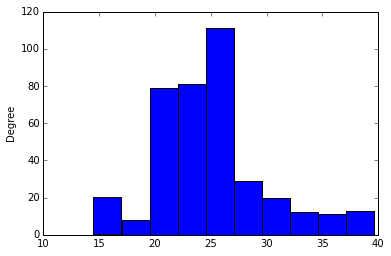

In [9]:
# plot histogram for each year, holding x axis fixed
df1[df1.year == 2014].value.plot(kind="hist")

compare earnings by location

In [11]:
# plt.plot(avg_yr_area.index.values, avg_yr_area)

scatterplot

time series plot of by major metropolitan areas

Having made these plots, what are some insights you get from them? Do you see any correlations? Is there a hypothesis you would like to investigate further? What other questions do they lead you to ask?

By now you’ve asked a bunch of questions, and found some neat insights. Is there an interesting narrative, a way of presenting the insights using text and plots from the above, that tells a compelling story? As you work out this story, what are some other trends/relationships you think will make it more complete? population will help determing national average. 
